<a href="https://colab.research.google.com/github/DzawilUqul/PersonDetection/blob/main/ComVis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Model SVM telah dilatih dan disimpan.
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        41
           1       0.95      0.90      0.92        20

    accuracy                           0.95        61
   macro avg       0.95      0.94      0.94        61
weighted avg       0.95      0.95      0.95        61



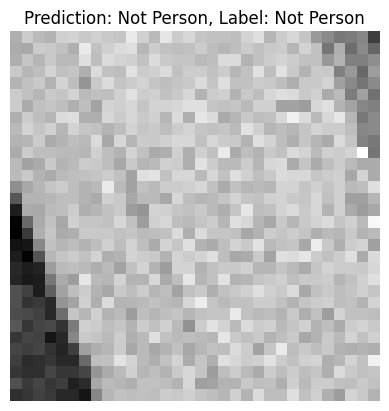

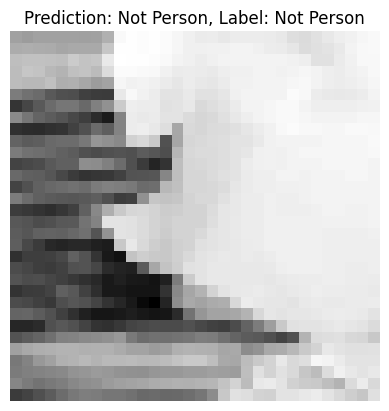

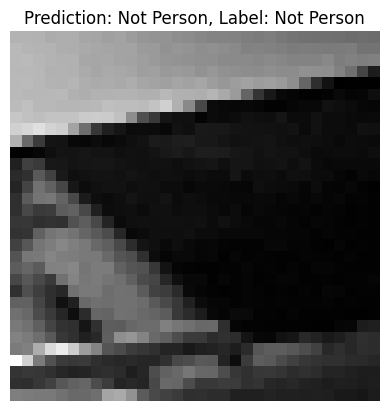

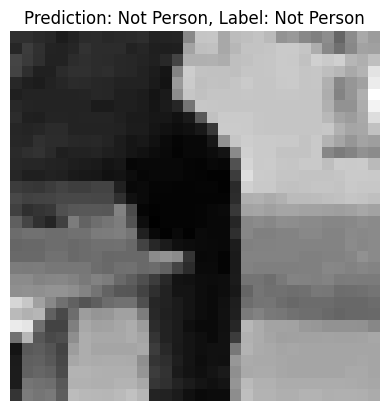

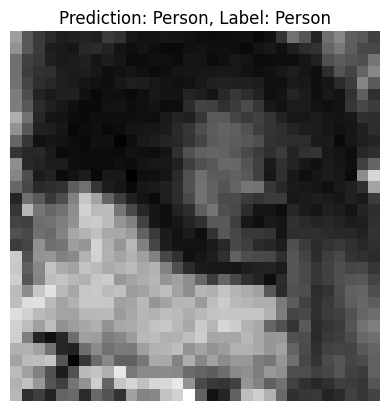

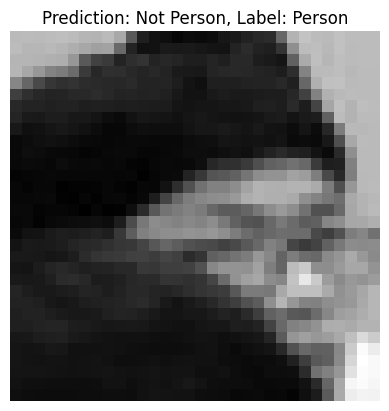

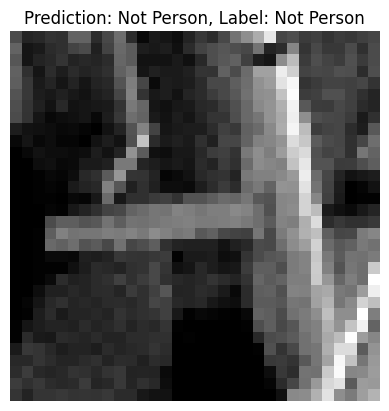

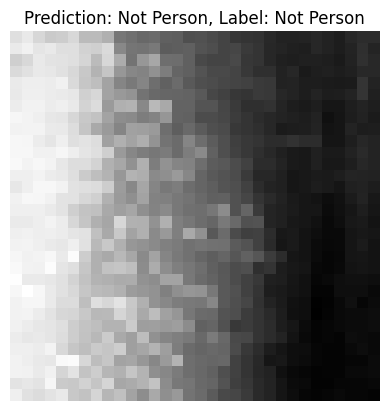

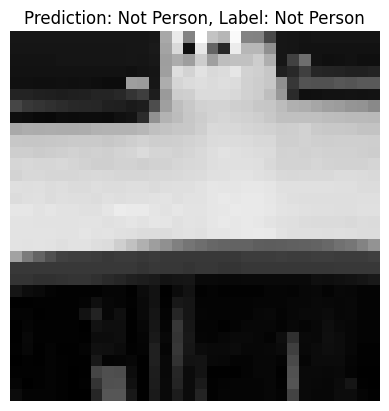

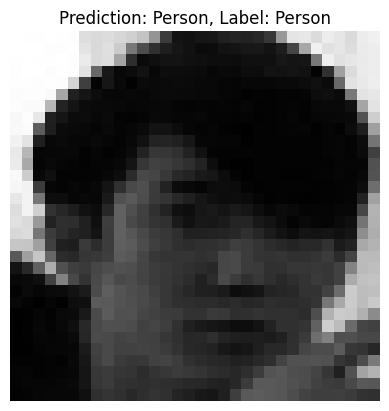

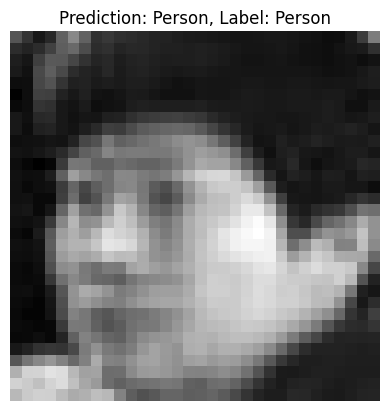

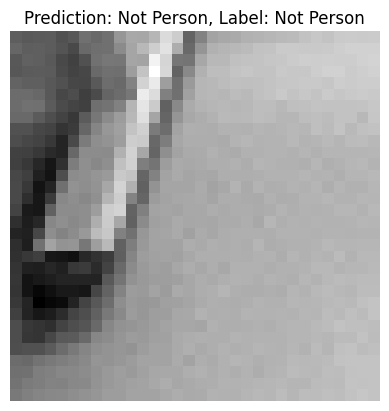

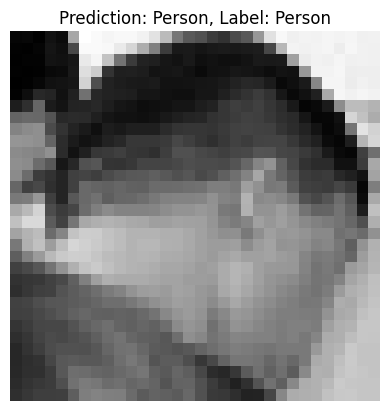

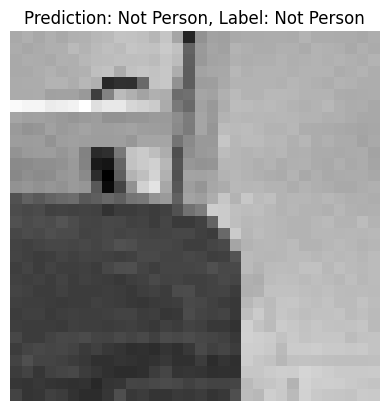

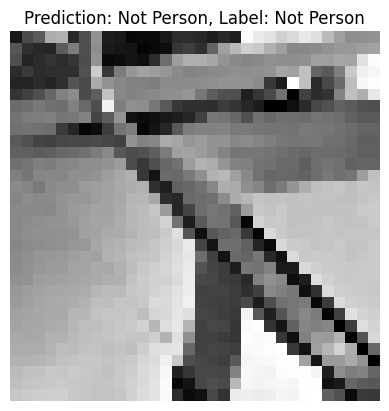

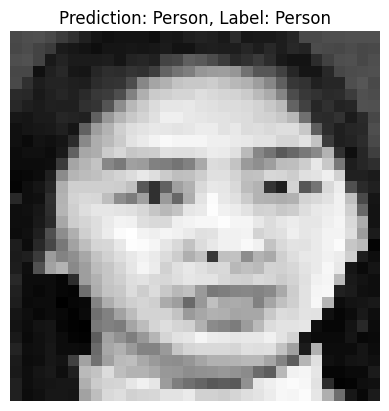

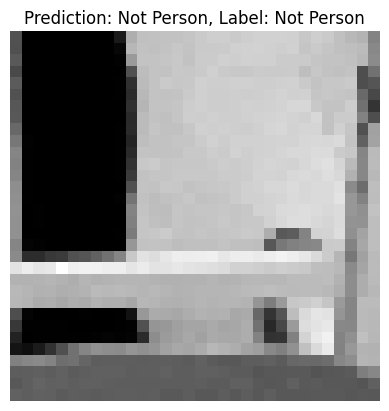

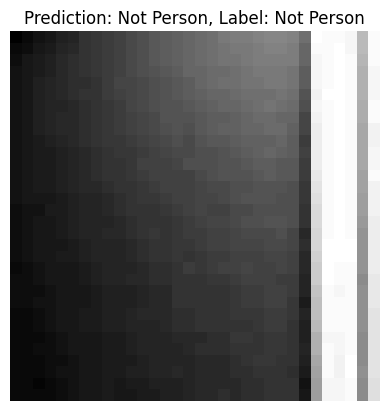

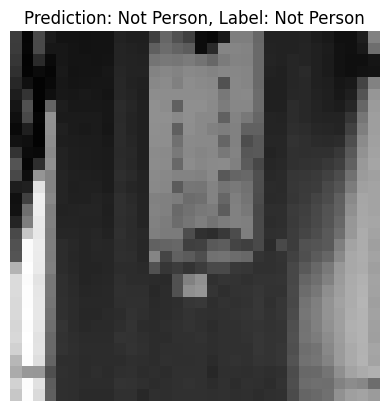

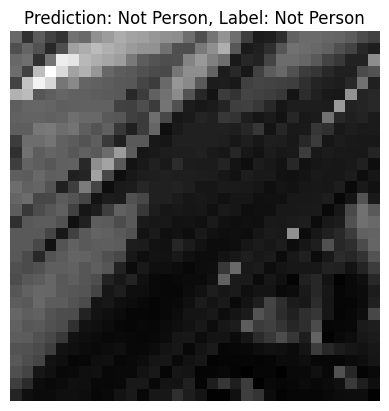

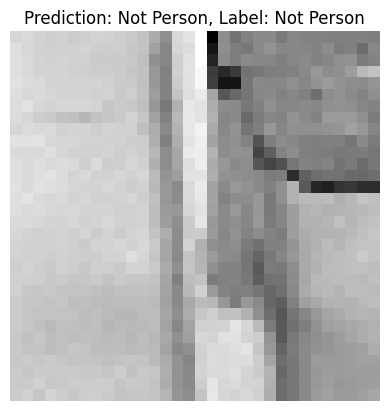

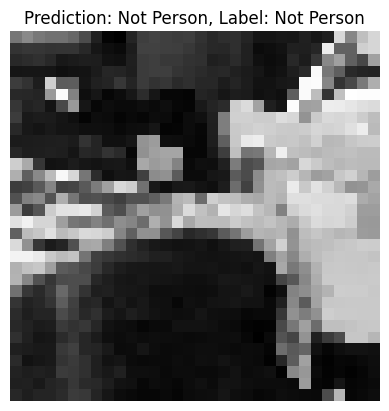

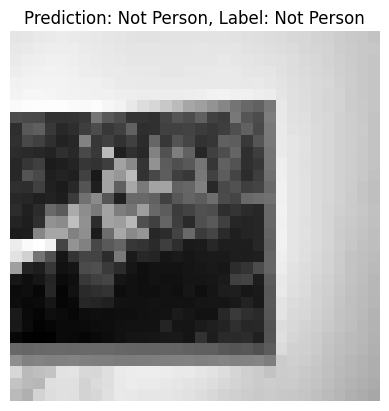

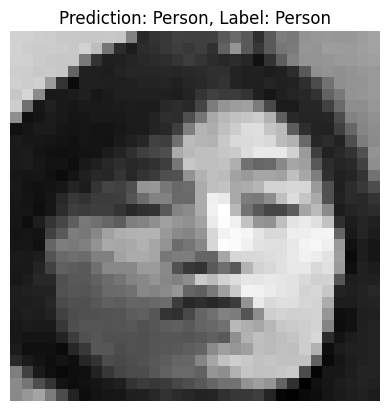

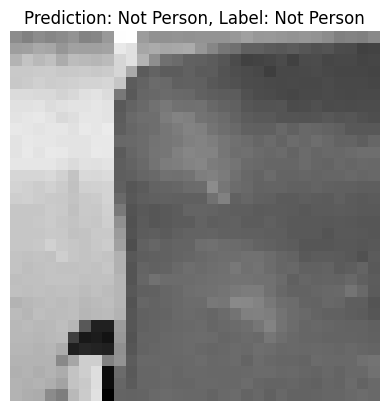

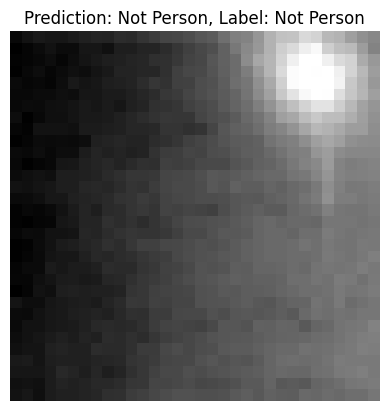

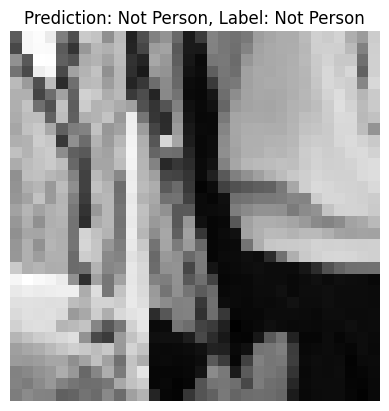

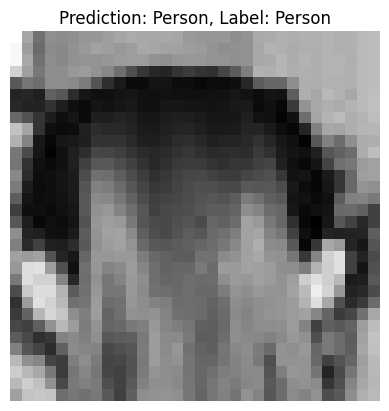

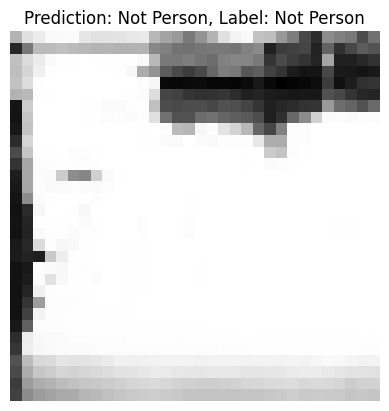

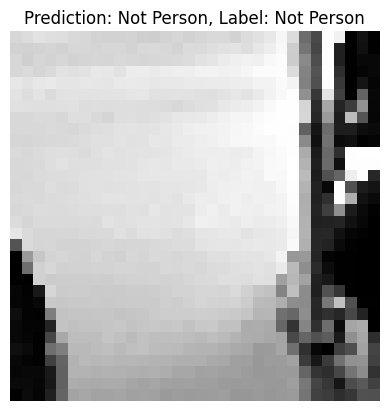

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Direktori gambar positif dan negatif
pos_dir = '/content/drive/MyDrive/Computer/pos'
neg_dir = '/content/drive/MyDrive/Computer/neg'

def load_images(image_dir):
    images = []
    labels = []
    for image_file in os.listdir(image_dir):
        if image_file.endswith(('jpg', 'png', 'jpeg')):
            img_path = os.path.join(image_dir, image_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(cv2.resize(img, (32, 32)))
                labels.append(1 if 'pos' in image_dir else 0)
    return images, labels

# Muat gambar positif dan negatif
pos_images, pos_labels = load_images(pos_dir)
neg_images, neg_labels = load_images(neg_dir)

X = np.array(pos_images + neg_images)
y = np.array(pos_labels + neg_labels)

# Ekstraksi fitur HOG
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(3, 3), orientations=9, block_norm='L2-Hys'):
    hog_features = []
    for image in images:
        features = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                       orientations=orientations, block_norm=block_norm, visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

hog_params = {'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3), 'orientations': 9, 'block_norm': 'L2-Hys'}
X_hog = extract_hog_features(X, **hog_params)

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

# Latih model SVM
svm = LinearSVC()
svm.fit(X_train, y_train)

# Simpan model yang telah dilatih
model_path = '/content/drive/MyDrive/Computer/svm_model.pkl'
joblib.dump(svm, model_path)

print("Model SVM telah dilatih dan disimpan.")

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

# Beberapa contoh hasil prediksi
# Ambil kembali gambar asli dari dataset X
X_train_orig, X_test_orig, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

for i in range(30):
    prediction = "Person" if y_pred[i] == 1 else "Not Person"
    label = "Person" if y_test[i] == 1 else "Not Person"
    plt.imshow(X_test_orig[i], cmap='gray')
    plt.title(f'Prediction: {prediction}, Label: {label}')
    plt.axis('off')
    plt.show()

Number of people detected: 52


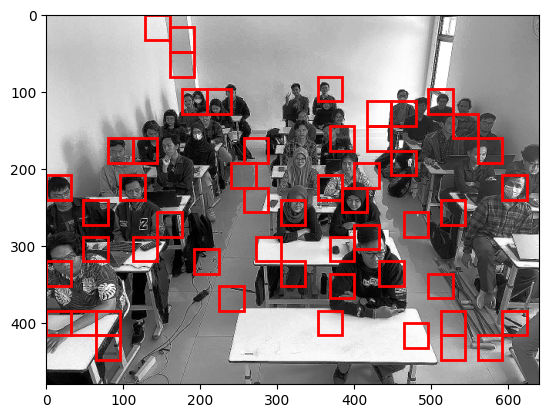

In [ ]:
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog

# Fungsi untuk deteksi menggunakan sliding window
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Fungsi untuk mendeteksi kepala pada gambar
def detect_heads(image, svm, window_size=(32, 32), step_size=16):
    detections = []
    for (x, y, window) in sliding_window(image, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        window_resized = cv2.resize(window, window_size)
        hog_features = hog(window_resized, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False)
        prediction = svm.predict([hog_features])
        if prediction == 1:
            detections.append((x, y, x + window_size[0], y + window_size[1]))
    return detections

# Fungsi Non-Maximum Suppression (NMS)
def non_max_suppression(boxes, overlap_thresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return boxes[pick].astype("int")

# Fungsi untuk pre-processing
def preprocess_image(image):
    equalized_image = cv2.equalizeHist(image)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(equalized_image, -1, kernel)

    return sharpened_image


svm = joblib.load('/content/drive/MyDrive/Computer/svm_model.pkl')


test_image_path = '/content/drive/MyDrive/Computer/test/Test5.jpeg'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Pre-processing
preprocessed_image = preprocess_image(test_image)


test_image_resized = cv2.resize(preprocessed_image, (preprocessed_image.shape[1] // 2, preprocessed_image.shape[0] // 2))

# Deteksi kepala
detections = detect_heads(test_image_resized, svm)


detections = np.array(detections)

#  Non-Maximum Suppression (NMS)
nms_detections = non_max_suppression(detections, overlap_thresh=0.1)

# Plot hasil deteksi
fig, ax = plt.subplots(1)
ax.imshow(test_image_resized, cmap='gray')
print(f"Number of people detected: {len(nms_detections)}")

# Display detections with bounding boxes
for (x1, y1, x2, y2) in nms_detections:
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none', linewidth=2)
    ax.add_patch(rect)

plt.show()
